# Установка библиотек

In [1]:
!pip install clickhouse-driver 

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.1/935.1 kB 3.6 MB/s eta 0:00:0000:0100:01m
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install vertica-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 1.2 MB/s eta 0:00:00a 0:00:01m
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [59]:
!pip install pandas tqdm numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.6 MB/s eta 0:00:0000:0100:01
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible re

# Импорт библиотек

In [90]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

import uuid
import random
from datetime import datetime

from clickhouse_driver import Client
import vertica_python

# Базовые функции

In [43]:
BATCH_SIZE = 1000
COUNT_BATCH = 2000000//BATCH_SIZE

ROWS = ['user_id', 'film_id', 'some_data', 'gender', 'timestamp']

def generate_random_data():
    batch = []
    for i in range(BATCH_SIZE):
        batch.append((
            uuid.uuid4(),
            uuid.uuid4(),
            random.randint(0, 1000),
            random.choice(['M', 'F']),
            datetime.now()
        ))
   

    return batch

In [35]:
generate_random_data()[0]

(UUID('70e2cca7-336c-4995-b2fe-670a62cb14b9'),
 UUID('6ff77048-c8f6-4c47-a340-ee138781bc21'),
 355,
 'M',
 datetime.datetime(2024, 2, 29, 15, 50, 47, 90707))

In [26]:
df = pd.DataFrame()

# ClickHouse

## 1. Подключение

In [28]:
clientCH = Client(host='localhost') 

## 2. Создание таблицы

In [29]:
clientCH.execute('SHOW DATABASES')

[('_temporary_and_external_tables',), ('default',), ('system',)]

In [32]:
clientCH.execute('CREATE DATABASE IF NOT EXISTS test_analytics;')

[]

In [40]:
init = """CREATE TABLE IF NOT EXISTS test_analytics.test (
    user_id UUID,
    film_id UUID,
    some_data UInt32,
    gender Enum('M'=1, 'F'=0),
    timestamp TIMESTAMP
)
Engine=MergeTree()
ORDER BY (user_id, film_id, timestamp);"""
clientCH.execute(init)

[]

## 3. Test

In [44]:
df['num'] = pd.Series([x for x in range(COUNT_BATCH)])

In [48]:
def test_insert(i):
    data = generate_random_data()
    now = datetime.now()
    clientCH.execute('INSERT INTO test_analytics.test (user_id, film_id, some_data, gender, timestamp) VALUES',
                     data)
    later = datetime.now()
    return (later-now).total_seconds()

In [49]:
df['ClickHouse insert'] = df['num'].progress_apply(test_insert)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 140.88it/s]


In [51]:
clientCH.execute('SELECT top 5 * FROM test_analytics.test')

[(UUID('ddb3412f-3a35-4416-8000-04070e17dfd7'),
  UUID('f2aa6e6c-a03c-4bd5-ab2c-8b8fc6731509'),
  802,
  'F',
  datetime.datetime(2024, 2, 29, 16, 4, 10)),
 (UUID('14fc291f-cc81-423a-8000-06b1877334d2'),
  UUID('0eb44e33-4706-49b0-bf70-43b3c3d85268'),
  280,
  'F',
  datetime.datetime(2024, 2, 29, 16, 4, 14)),
 (UUID('394a6bf0-4d08-45fd-8000-0c5bbbd54f35'),
  UUID('52a823a8-12b3-4959-ad36-57a0b29266e9'),
  922,
  'F',
  datetime.datetime(2024, 2, 29, 16, 4, 13)),
 (UUID('66de9a11-7816-44db-8000-10ac51fbb0b3'),
  UUID('af89a4fc-f45c-491c-8603-8b5e1a2c3fc9'),
  114,
  'F',
  datetime.datetime(2024, 2, 29, 16, 4, 13)),
 (UUID('c8d92d16-4137-4ffd-8000-153f905ca610'),
  UUID('ab83ba4f-38cf-4437-be6c-3a63d537b4b1'),
  313,
  'F',
  datetime.datetime(2024, 2, 29, 16, 4, 11))]

In [53]:
df['ClickHouse insert'].describe()

count    2000.000000
mean        0.003582
std         0.000471
min         0.002657
25%         0.003296
50%         0.003543
75%         0.003825
max         0.009686
Name: ClickHouse insert, dtype: float64

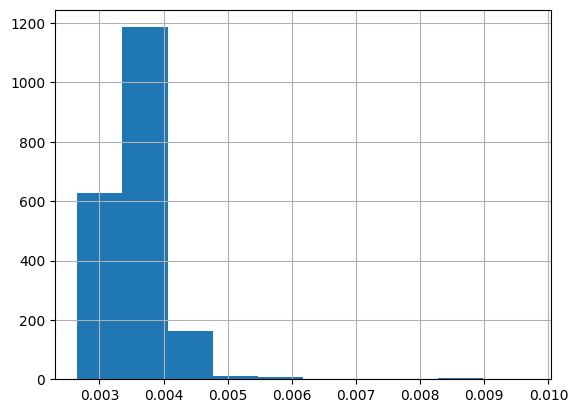

In [63]:
df['ClickHouse insert'].hist();

In [72]:
def test_select(i):
    i = random.randint(0, 1000)
    g = random.choice(['M', 'F'])
    now = datetime.now()
    clientCH.execute(f"SELECT * FROM test_analytics.test where some_data={i} and gender = '{g}'")
    later = datetime.now()
    return (later-now).total_seconds()

In [73]:
df['ClickHouse select_1'] = df['num'].progress_apply(test_select)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.43it/s]


In [76]:
def test_select(i):
    i = uuid.uuid4()
    now = datetime.now()
    clientCH.execute(f"SELECT * FROM test_analytics.test where user_id='{i}'")
    later = datetime.now()
    return (later-now).total_seconds()

In [77]:
df['ClickHouse select_2'] = df['num'].progress_apply(test_select)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 613.95it/s]


In [78]:
df['ClickHouse select_1'].describe()

count    2000.000000
mean        0.023971
std         0.013500
min         0.018744
25%         0.021166
50%         0.022210
75%         0.024217
max         0.232452
Name: ClickHouse select_1, dtype: float64

In [79]:
df['ClickHouse select_2'].describe()

count    2000.000000
mean        0.001604
std         0.000216
min         0.001260
25%         0.001477
50%         0.001559
75%         0.001673
max         0.004639
Name: ClickHouse select_2, dtype: float64

<Axes: >

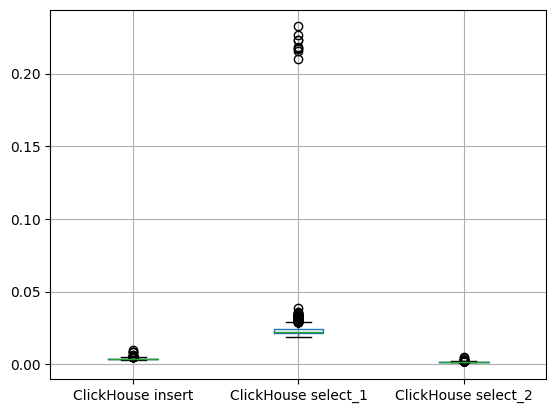

In [89]:
df[['ClickHouse insert', 'ClickHouse select_1','ClickHouse select_2']].boxplot()

# Vertica

## 1. Подключение

In [91]:
connection_info = {
    'host': '127.0.0.1',
    'port': 5433,
    'user': 'dbadmin',
    'password': '',
    'database': 'docker',
    'autocommit': True,
}

## 2. Создание таблицы

In [93]:
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    cursor.execute("""
    CREATE TABLE test (
        user_id UUID NOT NULL,
        film_id UUID NOT NULL,
        some_data INTEGER NOT NULL,
        gender VARCHAR(256) NOT NULL,
        timestamp TIMESTAMP NOT NULL
    );
    """)

In [96]:
with vertica_python.connect(**connection_info) as connection:
    cursor = connection.cursor()
    cursor.execute("""
        SELECT * FROM test;
    """)
    for row in cursor.iterate():
        print(row)

## 3. Test

In [121]:
def test_insert(i):
    data = generate_random_data()
    with vertica_python.connect(**connection_info) as connection: 
        now = datetime.now()
        with connection.cursor() as cursor:
            cursor.executemany('INSERT INTO test (user_id, film_id, some_data, gender, timestamp) VALUES (?,?,?,?,?);',
                       data,
                       use_prepared_statements=True)
            later = datetime.now()
    return (later-now).total_seconds()

In [122]:
df['Vertica insert'] = df['num'].progress_apply(test_insert)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:49:44<00:00,  3.29s/it]


In [123]:
df['Vertica insert'].describe()

count    2000.000000
mean        1.259983
std         0.254277
min         1.056288
25%         1.135452
50%         1.183557
75%         1.284933
max         2.737254
Name: Vertica insert, dtype: float64

In [126]:
def test_select(i):
    i = random.randint(0, 1000)
    g = random.choice(['M', 'F'])
    with vertica_python.connect(**connection_info) as connection:
        now = datetime.now()
        cursor = connection.cursor()  
        cursor.execute(f"SELECT * FROM test where some_data={i} and gender = '{g}'") 
        cursor.fetchall()
        later = datetime.now()
    return (later-now).total_seconds()

In [127]:
df['Vertica select_1'] = df['num'].progress_apply(test_select)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:45<00:00, 43.92it/s]


In [129]:
def test_select(i):
    i = uuid.uuid4()
    with vertica_python.connect(**connection_info) as connection:
        now = datetime.now()
        cursor = connection.cursor()  
        cursor.execute(f"SELECT * FROM test where user_id='{i}'") 
        cursor.fetchall()
        later = datetime.now()
    return (later-now).total_seconds()

In [130]:
df['Vertica select_2'] = df['num'].progress_apply(test_select)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 148.42it/s]


# Сравнение

<Axes: ylabel='Frequency'>

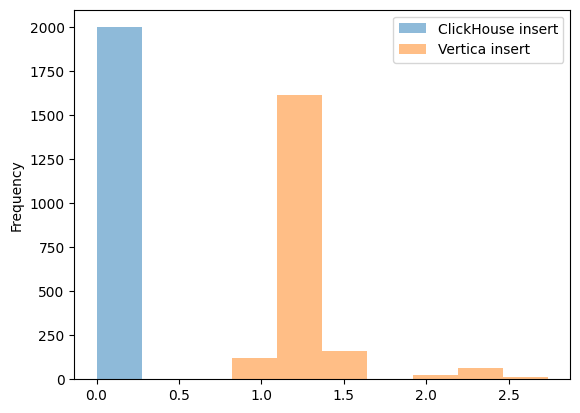

In [125]:
df[['ClickHouse insert', 'Vertica insert']].plot.hist(alpha=0.5)

In [147]:
df['Vertica insert'].mean() - df['ClickHouse insert'].mean() 

1.2564008325

<Axes: ylabel='Frequency'>

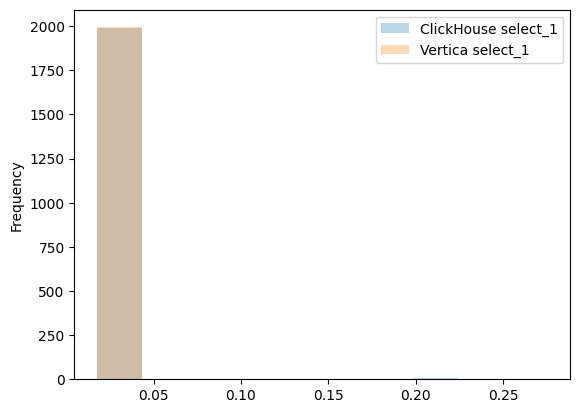

In [134]:
df[['ClickHouse select_1','Vertica select_1']].plot.hist(alpha=0.3)

<Axes: ylabel='Frequency'>

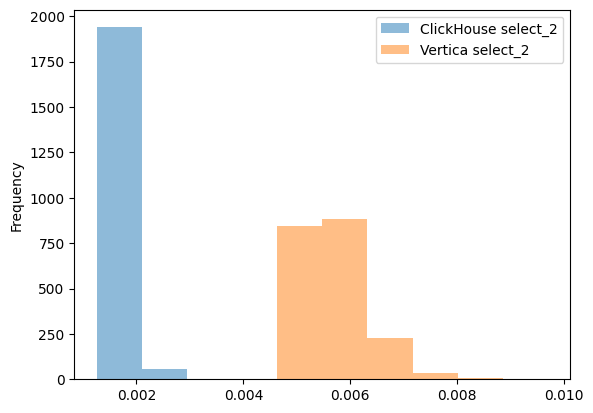

In [136]:
df[['ClickHouse select_2','Vertica select_2']].plot.hist(alpha=0.5)

<Axes: >

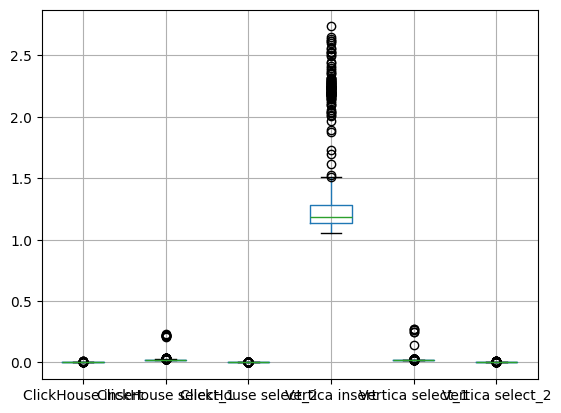

In [137]:
df[['ClickHouse insert', 'ClickHouse select_1','ClickHouse select_2', 'Vertica insert', 'Vertica select_1','Vertica select_2']].boxplot()

<Axes: >

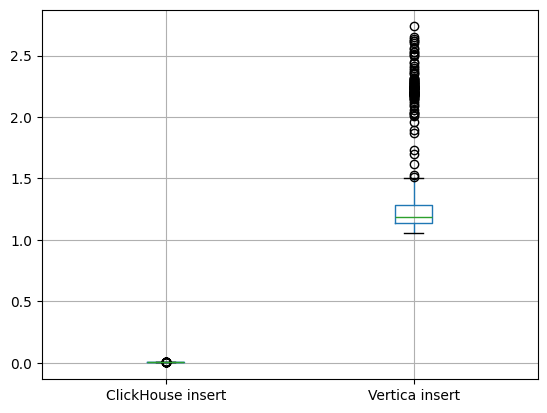

In [138]:
df[['ClickHouse insert', 'Vertica insert']].boxplot()

<Axes: >

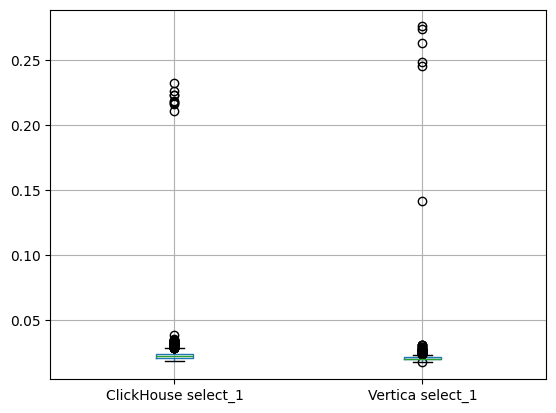

In [140]:
df[['ClickHouse select_1', 'Vertica select_1']].boxplot()

<Axes: >

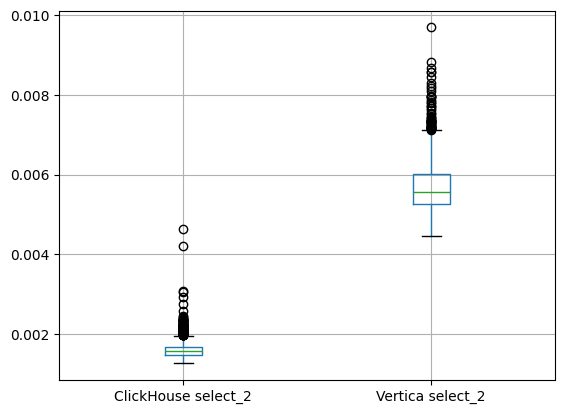

In [141]:
df[['ClickHouse select_2', 'Vertica select_2']].boxplot()